<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/data_driven-Mobilnetwork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img

In [4]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [10]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        if self.spike is not None:
            return self.stimulus[idx], self.spike[idx]
        else:
            return self.stimulus[idx]

In [11]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=64, shuffle=False)
ITdataloader_test = DataLoader(SpikeData(stimulus_test,spike = None), batch_size=64, shuffle=False)

In [ ]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [7]:
class MobilnetStudent(nn.Module):
    def __init__(self, num_neuron):
        super(MobilnetStudent, self).__init__()
        self.model = nn.Sequential(
            # Initial Convolutional Block 1
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1, bias=False),  # Downsample early
            nn.BatchNorm2d(8),
            nn.ReLU6(inplace=True),

            # Convolutional Block 2
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Convolutional Block 3
            nn.Conv2d(16, 24, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(24),

            # Inverted Residual Block (lightweight)
            nn.Conv2d(24, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU6(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1, groups=48, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU6(inplace=True),
            nn.Conv2d(48, 24, kernel_size=1, bias=False),
            nn.BatchNorm2d(24),

            # Downsampling block
            nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            # Final Block
            nn.Conv2d(32, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(32 * 1 * 1, num_neuron)
        )

    def forward(self, x):
        out = self.model(x)
        return out

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [12]:
class MobilnetStudent2(nn.Module):
    def __init__(self, num_neuron):
        super(MobilnetStudent2, self).__init__()
        self.model = nn.Sequential(
            # Initial Convolutional Block 1
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU6(inplace=True),

            # Convolutional Block 2
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Convolutional Block 3
            nn.Conv2d(16, 32, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(32),

            # First Inverted Residual Block
            nn.Conv2d(32, 64, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 32, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(32),

            # Convolutional Block 4 (downsampling to 16x16)
            nn.Conv2d(32, 64, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            # Convolutional Block 5
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),

            # Convolutional Block 6
            nn.Conv2d(128, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),

            # Second Inverted Residual Block
            nn.Conv2d(128, 256, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(128),

            # Final Expansion and Projection Layer
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, num_neuron)
        )

    def forward(self, x):
        out = self.model(x)
        return out

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [13]:
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, spikes in train_loader:
                stimulus, spikes = stimulus.to(device), spikes.to(device)
                optimizer.zero_grad()

                outputs = model(stimulus)
                loss = criterion(outputs, spikes)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step(val_loss)

        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)

    return model

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.MSELoss()
#model = ShallowCNN2(num_neuron=168)
#model.apply(ShallowCNN2.init_weights)
model = MobilnetStudent2(num_neuron=168)
model.apply(MobilnetStudent2.init_weights)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=60, scheduler=scheduler)

save_path = '/content/drive/MyDrive/nx414/MobilnetStudent2.pth'
torch.save(model.state_dict(), save_path)

Epoch 1/60: 100%|██████████| 41/41 [00:24<00:00,  1.69it/s, loss=0.181]


Epoch [1/60], Train Loss: 0.1810
Validation Loss: 0.1402


Epoch 2/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.134]


Epoch [2/60], Train Loss: 0.1343
Validation Loss: 0.1365


Epoch 3/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.132]


Epoch [3/60], Train Loss: 0.1316
Validation Loss: 0.1598


Epoch 4/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.128]


Epoch [4/60], Train Loss: 0.1280
Validation Loss: 0.1315


Epoch 5/60: 100%|██████████| 41/41 [00:22<00:00,  1.79it/s, loss=0.124]


Epoch [5/60], Train Loss: 0.1240
Validation Loss: 0.1266


Epoch 6/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.121]


Epoch [6/60], Train Loss: 0.1211
Validation Loss: 0.1259


Epoch 7/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.119]


Epoch [7/60], Train Loss: 0.1193
Validation Loss: 0.1224


Epoch 8/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.115]


Epoch [8/60], Train Loss: 0.1153
Validation Loss: 0.1228


Epoch 9/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.113]


Epoch [9/60], Train Loss: 0.1134
Validation Loss: 0.1215


Epoch 10/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.111]


Epoch [10/60], Train Loss: 0.1111
Validation Loss: 0.1592


Epoch 11/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.109]


Epoch [11/60], Train Loss: 0.1093
Validation Loss: 0.1156


Epoch 12/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.108]


Epoch [12/60], Train Loss: 0.1078
Validation Loss: 0.1097


Epoch 13/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.107]


Epoch [13/60], Train Loss: 0.1065
Validation Loss: 0.1077


Epoch 14/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.105]


Epoch [14/60], Train Loss: 0.1046
Validation Loss: 0.1087


Epoch 15/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.104]


Epoch [15/60], Train Loss: 0.1038
Validation Loss: 0.1115


Epoch 16/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.103]


Epoch [16/60], Train Loss: 0.1033
Validation Loss: 0.1224


Epoch 17/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.102]


Epoch [17/60], Train Loss: 0.1025
Validation Loss: 0.1027


Epoch 18/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.102]


Epoch [18/60], Train Loss: 0.1020
Validation Loss: 0.1105


Epoch 19/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.101]


Epoch [19/60], Train Loss: 0.1010
Validation Loss: 0.1041


Epoch 20/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.1]


Epoch [20/60], Train Loss: 0.1003
Validation Loss: 0.1094


Epoch 21/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.0995]


Epoch [21/60], Train Loss: 0.0995
Validation Loss: 0.1038


Epoch 22/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0981]


Epoch [22/60], Train Loss: 0.0981
Validation Loss: 0.1008


Epoch 23/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.098]


Epoch [23/60], Train Loss: 0.0980
Validation Loss: 0.1200


Epoch 24/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0972]


Epoch [24/60], Train Loss: 0.0972
Validation Loss: 0.1262


Epoch 25/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0965]


Epoch [25/60], Train Loss: 0.0965
Validation Loss: 0.1058


Epoch 26/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0962]


Epoch [26/60], Train Loss: 0.0962
Validation Loss: 0.0992


Epoch 27/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.0954]


Epoch [27/60], Train Loss: 0.0954
Validation Loss: 0.1081


Epoch 28/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.0945]


Epoch [28/60], Train Loss: 0.0945
Validation Loss: 0.0986


Epoch 29/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.0939]


Epoch [29/60], Train Loss: 0.0939
Validation Loss: 0.0991


Epoch 30/60: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s, loss=0.0934]


Epoch [30/60], Train Loss: 0.0934
Validation Loss: 0.1048


Epoch 31/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.0932]


Epoch [31/60], Train Loss: 0.0932
Validation Loss: 0.0996


Epoch 32/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.0922]


Epoch [32/60], Train Loss: 0.0922
Validation Loss: 0.0991


Epoch 33/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0919]


Epoch [33/60], Train Loss: 0.0919
Validation Loss: 0.0972


Epoch 34/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0908]


Epoch [34/60], Train Loss: 0.0908
Validation Loss: 0.1071


Epoch 35/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0905]


Epoch [35/60], Train Loss: 0.0905
Validation Loss: 0.0970


Epoch 36/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0901]


Epoch [36/60], Train Loss: 0.0901
Validation Loss: 0.0947


Epoch 37/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0894]


Epoch [37/60], Train Loss: 0.0894
Validation Loss: 0.0956


Epoch 38/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0888]


Epoch [38/60], Train Loss: 0.0888
Validation Loss: 0.0949


Epoch 39/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0887]


Epoch [39/60], Train Loss: 0.0887
Validation Loss: 0.0939


Epoch 40/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0877]


Epoch [40/60], Train Loss: 0.0877
Validation Loss: 0.0968


Epoch 41/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0873]


Epoch [41/60], Train Loss: 0.0873
Validation Loss: 0.0993


Epoch 42/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0867]


Epoch [42/60], Train Loss: 0.0867
Validation Loss: 0.1000


Epoch 43/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0866]


Epoch [43/60], Train Loss: 0.0866
Validation Loss: 0.0930


Epoch 44/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0862]


Epoch [44/60], Train Loss: 0.0862
Validation Loss: 0.0943


Epoch 45/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0851]


Epoch [45/60], Train Loss: 0.0851
Validation Loss: 0.0913


Epoch 46/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0844]


Epoch [46/60], Train Loss: 0.0844
Validation Loss: 0.0923


Epoch 47/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0843]


Epoch [47/60], Train Loss: 0.0843
Validation Loss: 0.1017


Epoch 48/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0838]


Epoch [48/60], Train Loss: 0.0838
Validation Loss: 0.1000


Epoch 49/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0835]


Epoch [49/60], Train Loss: 0.0835
Validation Loss: 0.0924


Epoch 50/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0828]


Epoch [50/60], Train Loss: 0.0828
Validation Loss: 0.0898


Epoch 51/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0827]


Epoch [51/60], Train Loss: 0.0827
Validation Loss: 0.0957


Epoch 52/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0823]


Epoch [52/60], Train Loss: 0.0823
Validation Loss: 0.0932


Epoch 53/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0821]


Epoch [53/60], Train Loss: 0.0821
Validation Loss: 0.0928


Epoch 54/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0809]


Epoch [54/60], Train Loss: 0.0809
Validation Loss: 0.0978


Epoch 55/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0804]


Epoch [55/60], Train Loss: 0.0804
Validation Loss: 0.0923


Epoch 56/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.082]


Epoch [56/60], Train Loss: 0.0820
Validation Loss: 0.0965


Epoch 57/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.0781]


Epoch [57/60], Train Loss: 0.0781
Validation Loss: 0.0867


Epoch 58/60: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s, loss=0.076]


Epoch [58/60], Train Loss: 0.0760
Validation Loss: 0.0869


Epoch 59/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.0753]


Epoch [59/60], Train Loss: 0.0753
Validation Loss: 0.0865


Epoch 60/60: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s, loss=0.075]


Epoch [60/60], Train Loss: 0.0750
Validation Loss: 0.0868


In [ ]:
load_path = '/content/drive/MyDrive/nx414/shallow_cnn2.pth'
model = ShallowCNN2(num_neuron=168)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [15]:
model.eval()

prediction_train = []

ITdataloader_train2 = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=False)

with torch.no_grad():
    for stimulus, _ in ITdataloader_train2:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)
prediction_train.shape

torch.Size([2592, 168])

In [16]:
model.eval()

prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)
prediction_val.shape

torch.Size([288, 168])

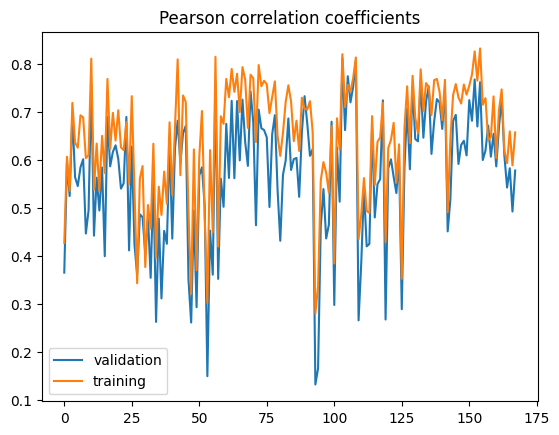

Pearson correlation on training set: 0.6450281134803293
Pearson correlation on validation set: 0.5706472028091237


<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

n_neurons = spikes_train.shape[1]

pearson_corr_shallowcnn = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_shallowcnn[i,0] = np.corrcoef(spikes_train[:, i],prediction_train[:, i])[0, 1]
    pearson_corr_shallowcnn[i,1] = np.corrcoef(spikes_val[:, i],prediction_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_shallowcnn[:,1], label='validation')
plt.plot(pearson_corr_shallowcnn[:,0], label='training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_shallowcnn[:,0])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_shallowcnn[:,1])}")

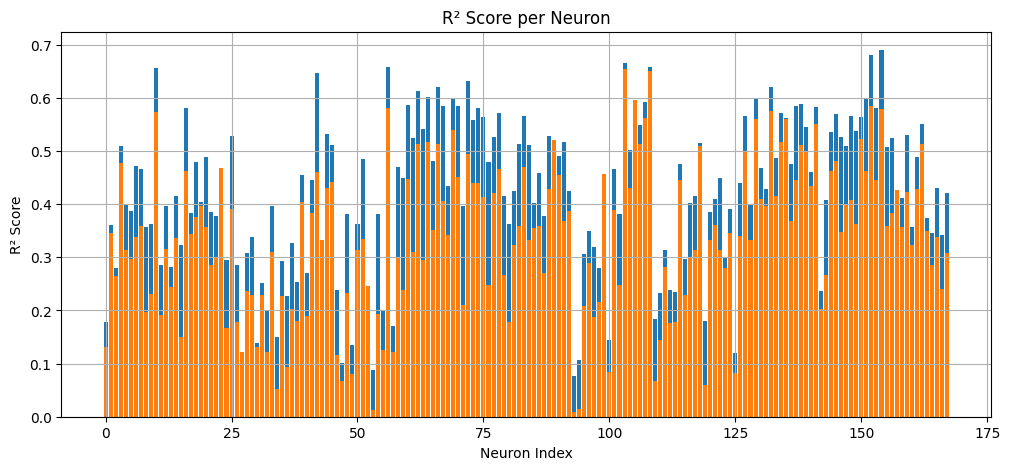

In [18]:
from sklearn.metrics import r2_score

r2_train = [r2_score(spikes_train[:, i], prediction_train[:, i]) for i in range(spikes_train.shape[1])]
r2_val = [r2_score(spikes_val[:, i], prediction_val[:, i]) for i in range(spikes_val.shape[1])]

plt.figure(figsize=(12, 5))
plt.bar(range(len(r2_train)), r2_train)
plt.bar(range(len(r2_val)), r2_val)
plt.xlabel('Neuron Index')
plt.ylabel('R² Score')
plt.title('R² Score per Neuron')
plt.grid(True)
plt.show()

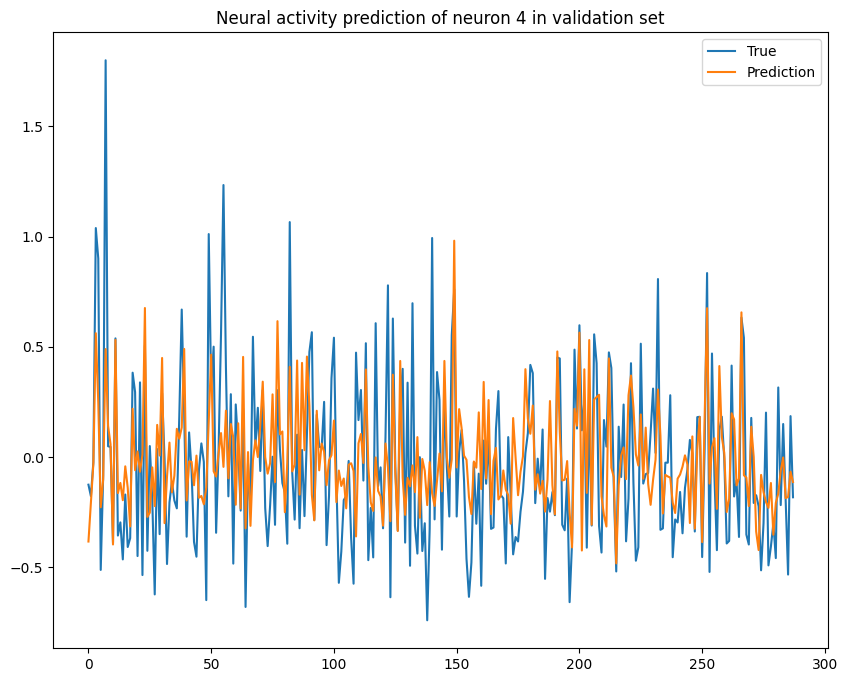

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in validation set')
plt.plot(spikes_val[:,example_id], label = "True")
plt.plot(prediction_val[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()

In [20]:
model.eval()

prediction_test = []

with torch.no_grad():
    for stimulus in ITdataloader_test:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_test.append(outputs.cpu())

prediction_test = torch.cat(prediction_test, dim=0)
prediction_test.shape

torch.Size([320, 168])

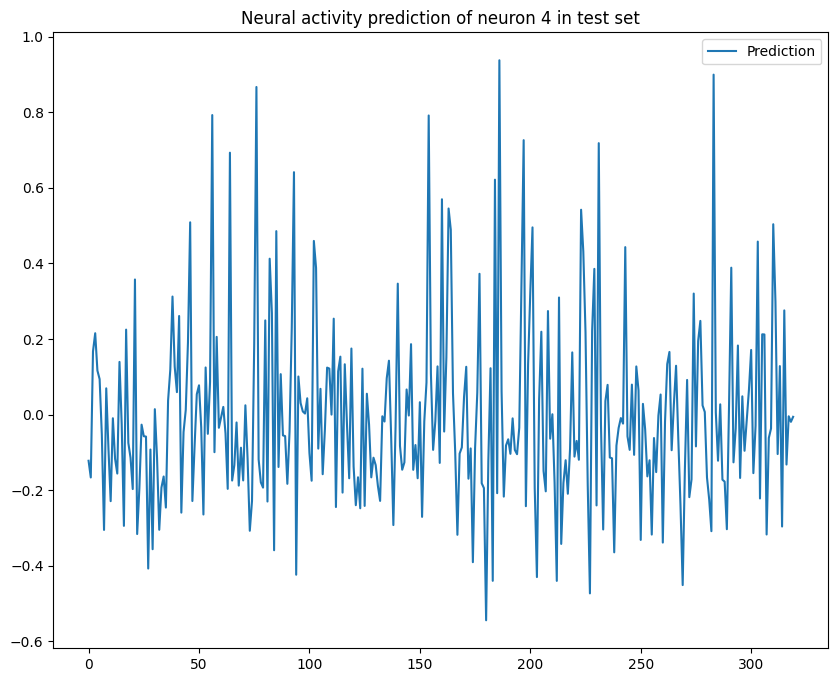

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in test set')
plt.plot(prediction_test[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()